**ESERCIZITAZIONE 8:**

Problema di ottimizzazione. L'obiettivo è calcolare l'autovalore del ground state di una Hamiltoniana con un principio variazionale, facendo variare i parametri dell'autofunzione sulla quale si calcola il valore di aspettazione dell'energeia

    

**Esercizio 8.1:** Data una scelta dei parametri $(\mu, \sigma)$, campionare con Metropolis la densità di probabilità data dal modulo quadro dell'autofunzione:

$\Psi_{\mu, \sigma}(x) = e^{-(x - \mu)^2 / 2\sigma^2} + e^{-(x + \mu)^2 / 2\sigma^2}$ 

Viene riportato un istogramma dei punti x campionati, con sovraimpressa $|\Psi_{\mu, \sigma}(x)|^2$ :

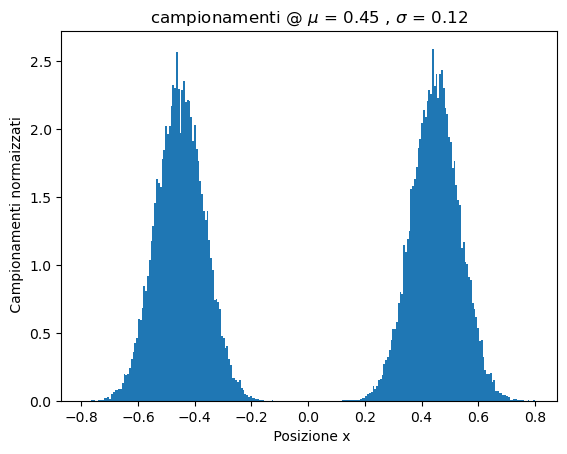

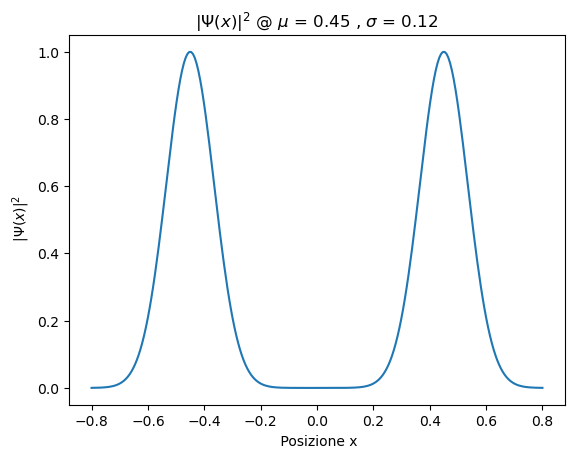

In [1]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

#Lettura file
filename = "output_positions.txt"
POS = pd.read_table(filename, delimiter = "\t" , usecols=(0,1) , names = ('Num','X') , header = 0)

#estrarre i dati dalle colonne del file di testo
POS['X'] = pd.to_numeric(POS['X'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
position_vector = POS['X']
    
plt.hist(position_vector, bins = 250, density = 'True')
plt.title("campionamenti @ $\mu$ = 0.45 , $\sigma$ = 0.12")
plt.xlabel(" Posizione x")
plt.ylabel(" Campionamenti normaizzati")
plt.show()
# funzione analitica della densità di probabilità
mu = 0.45
sigma = 0.12
x = np.linspace(-0.8 , 0.8 , 250)
def f(x):
    return np.exp(-(x-mu)**2 / (2 * sigma**2)) + np.exp(-(x+mu)**2 / (2 * sigma**2))

plt.plot(x, f(x)**2)
plt.title("$|\Psi(x)|^2$ @ $\mu$ = 0.45 , $\sigma$ = 0.12")
plt.xlabel(" Posizione x")
plt.ylabel(" $|\Psi(x)|^2$")
plt.show()

    

Calcolare il valore di aspettazione dell'energia. Ne è riportata la statistica usando, come di consueto, il data blocking.

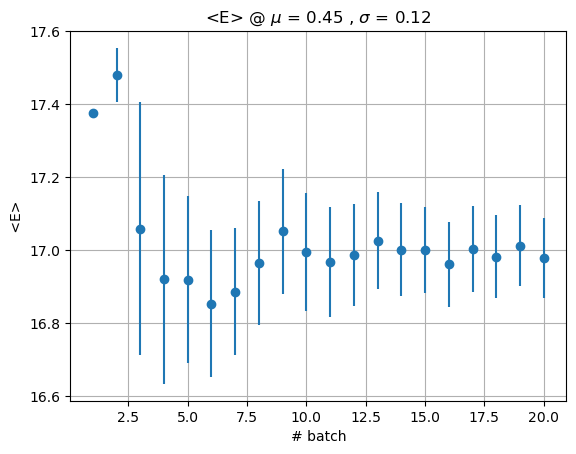

In [2]:
#Lettura file
filename = "output_stats.txt"
E = pd.read_table(filename, delimiter = "\t" , usecols=(0,5,6,7) , names = ('Blk','Actual','Mean','Stdev') , header = 0)

#estrarre i dati dalle colonne del file di testo
E['Blk'] = pd.to_numeric(E['Blk'] , errors = 'coerce')
E['Actual'] = pd.to_numeric(E['Actual'] , errors = 'coerce')
E['Mean'] = pd.to_numeric(E['Mean'] , errors = 'coerce')
E['Stdev'] = pd.to_numeric(E['Stdev'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
block_vector = E['Blk']
actual_vector = E['Actual']
mean_vector = E['Mean']
stdev_vector = E['Stdev']

#grafico della media globale del valore di aspettazione dell'energia
plt.errorbar(block_vector, mean_vector, yerr = stdev_vector, fmt = 'o')
plt.grid(True)
plt.xlabel("# batch")
plt.ylabel(" <E> ")
plt.title("<E> @ $\mu$ = 0.45 , $\sigma$ = 0.12")
plt.show()

**Esercizio 8.2:** Calcolare il minimo del valore di aspettazione sullo spazio dei parametri $(\mu, \sigma)$. E' un problema di ottimizzazione su tale spazio bidimensionale, che si risolve con un metodo di Simulated Annealing. L'architettura dell'algoritmo è costituita da tre cicli iterativi annidati:

1. Il ciclo interno, i cui passi sono conteggiati dall'indice $k$, identifica i punti nello spazio reale $x$ da campionare con l'algoritmo Metropolis, secondo la distribuzione di probabilità $|\Psi_{\mu, \sigma}|^2$, al fine di calcolare il valore di aspettazione dell'energia $<E>$ data una posizione fissata nello spazio dei parametri $(\mu, \sigma)$. Si deve scegliere come iperparametro un numero $K$ sufficientemente grande da poter calcolare l'integrale dell'Hamiltoniana. Inoltre, come già accennato prima, si deve fissare un valore $L_3$ del passo di campionamento delle mosse di Metropolis tale da ricostruire correttamente la distribuzione di probabilità desiderata.

2. Il ciclo intermedio, le cui iterazioni sono identificate dall'indice $i$, è rappresentato dalla successione degli step di Simulated Annealing all'interno di un blocco. Ogni step, partendo da un punto iniziale nello spazio dei parametri $(\mu, \sigma)$, prevede il calcolo di $<E>$ usando il ciclo interno. Successivamente, si propone una mossa $(\Delta\mu, \Delta\sigma)$, estratta con un range $(L_1 , L_2)$, per poi calcolare $<E_{new}>$ data la nuova posizione sullo spazio dei parametri. L'accettazione di tale mossa è valutata con l'algoritmo Metropolis applicato alla distribuzione di probabilità di Boltzmann $e^{-\beta <E>}$. Si deve scegliere un numero $N$ opportuno di passi di SA da includere in ogni blocco.

3. Il ciclo esterno, campionato dall'indice $j$, rappresenta la successione di $M$ blocchi che completa il Simulated Annealing. All'interno di ciascun blocco $j$-esimo, gli $N$ step di SA avvengono a  $\beta$ fissato. La lentezza del raffreddamento è garantita anche da una crescita di $\beta$, da un batch all'altro, che, in questo caso particolare, è stata scelta con la seguente successione per ricorrenza: $\beta_{j+1} = \beta_{j} + \alpha*(1 - j/M)$. Tale legge, oltre ad assicurare una crescita lenta grazie all'iperparametro $\alpha$ deciso a priori in $(0,1)$, permette di saturare il valore di $\beta$ per un numero alto di blocchi, per evitare l'overflow o l'underflow dell'esponenziale $e^{-\beta <E>}$. Infine, è possibile impostare $(L_1, L_2)$ come range adattivi, che si restringono lievemente ad ogni blocco, in modo tale che, dopo un numero sufficiente di batch, la ricerca nello spazio dei parametri sia ben localizzata attorno al minimo globale. In particolare, si è applicata la seguente legge: $L_{j + 1} = L_{j} * 0.9995*(0.05 * (j/M) + 0.95)$. 

--- Il sistema parte dai seguenti parametri: 
($\mu$, $\sigma$) = (1.59, -0.94)
L_1 = L_2 = 0.04
T = 0.89
--- L'algoritmo si avvale dei seguenti iperparametri, che, rimanendo fissati, ne determinano l'architettura: 
L_3 = 2.05
(N_1, M, N, K) = (2500, 100, 600, 11000)
alfa = 0.8


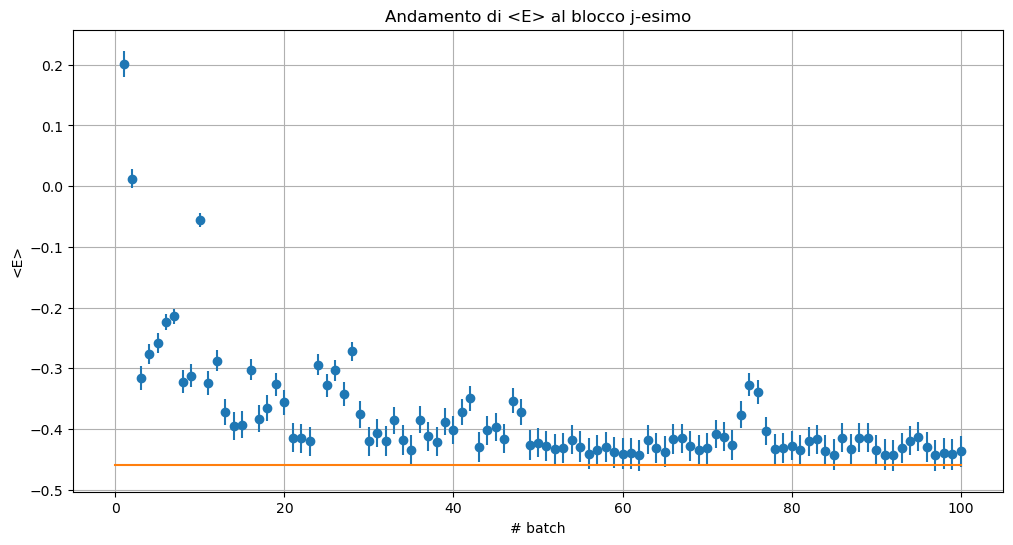

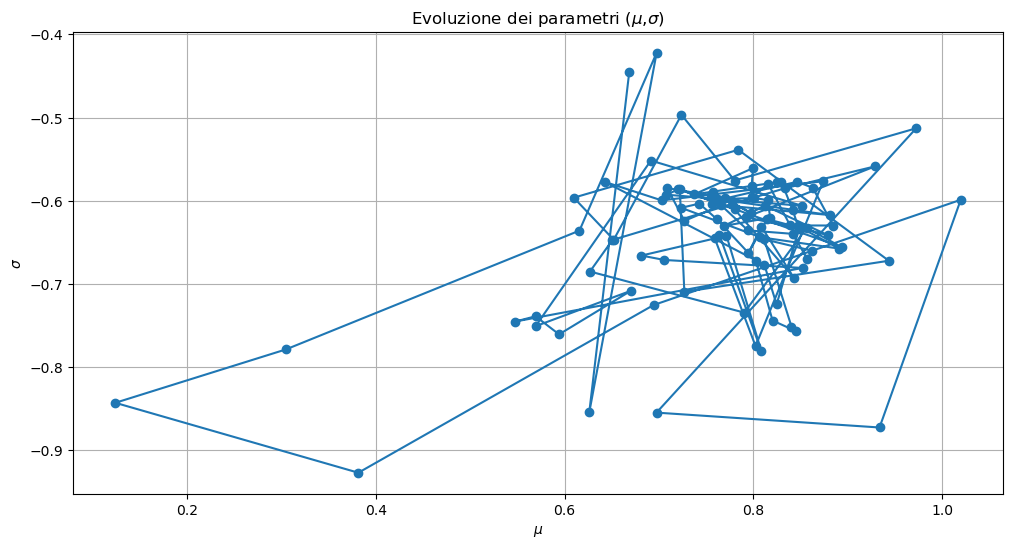

In [3]:
#Lettura file
filename = "output_stats_SA.txt"
SA = pd.read_table(filename, delimiter = "\t" , usecols=(0,1,2,3,4) , names = ('Blk','Current', 'Stdev' , 'mu' , 'sigma') )

#estrarre i dati dalle colonne del file di testo
SA['Blk'] = pd.to_numeric(SA['Blk'] , errors = 'coerce')
SA['Current'] = pd.to_numeric(SA['Current'] , errors = 'coerce')
SA['Stdev'] = pd.to_numeric(SA['Stdev'] , errors = 'coerce')
SA['mu'] = pd.to_numeric(SA['mu'] , errors = 'coerce')
SA['sigma'] = pd.to_numeric(SA['sigma'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
Block_vector = SA['Blk']
Current_vector = SA['Current']
Stdev_vector = SA['Stdev']
mu_vector = SA['mu'] 
sigma_vector =  SA['sigma']
Expected_vector = np.zeros(len(Block_vector))
Expected_vector = Expected_vector - 0.46

#report sugli iperparametri utilizzati:
print("--- Il sistema parte dai seguenti parametri: ")
print("($\mu$, $\sigma$) = (1.59, -0.94)")
print("L_1 = L_2 = 0.04")
print("T = 0.89")

print("--- L'algoritmo si avvale dei seguenti iperparametri, che, rimanendo fissati, ne determinano l'architettura: ")
print("L_3 = 2.05")
print("(N_1, M, N, K) = (2500, 100, 600, 11000)")
print("alfa = 0.8")

#rappresentare il grafico della media globale di <E>
plt.figure(figsize = (12,6))
plt.errorbar(Block_vector, Current_vector, yerr = Stdev_vector, fmt = 'o')
plt.plot(Expected_vector)
plt.title("Andamento di <E> al blocco j-esimo")
plt.ylabel("<E>")
plt.xlabel("# batch")
plt.grid(True)
plt.show()

plt.figure(figsize = (12,6))
plt.plot(mu_vector, sigma_vector , marker = 'o' ,  linestyle = '-')
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")
plt.title("Evoluzione dei parametri ($\mu$,$\sigma$)")
plt.grid(True)
plt.show()


Ora si procede al confronto tra la distribuione dei punti $x$ campionati con Metropolis per calcolare il valore di $<E>$ e la funzione analitica $\psi(x)$ corrispondente al minimo di tale integrale:

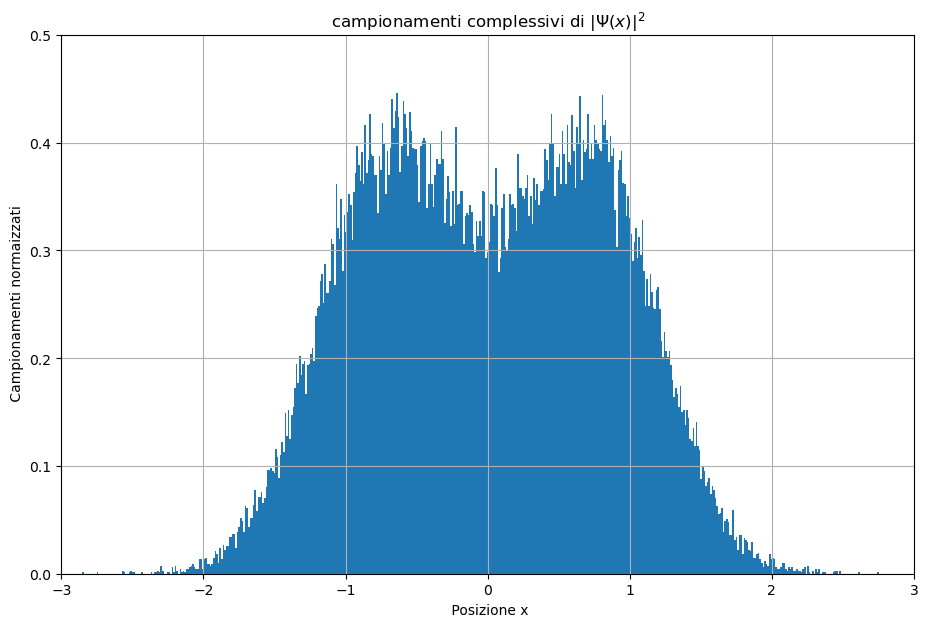

Ground state energy:  -0.4604658796927152
1st excited state energy:  0.0974247133176099
2nd excited state energy:  1.9717331343930193


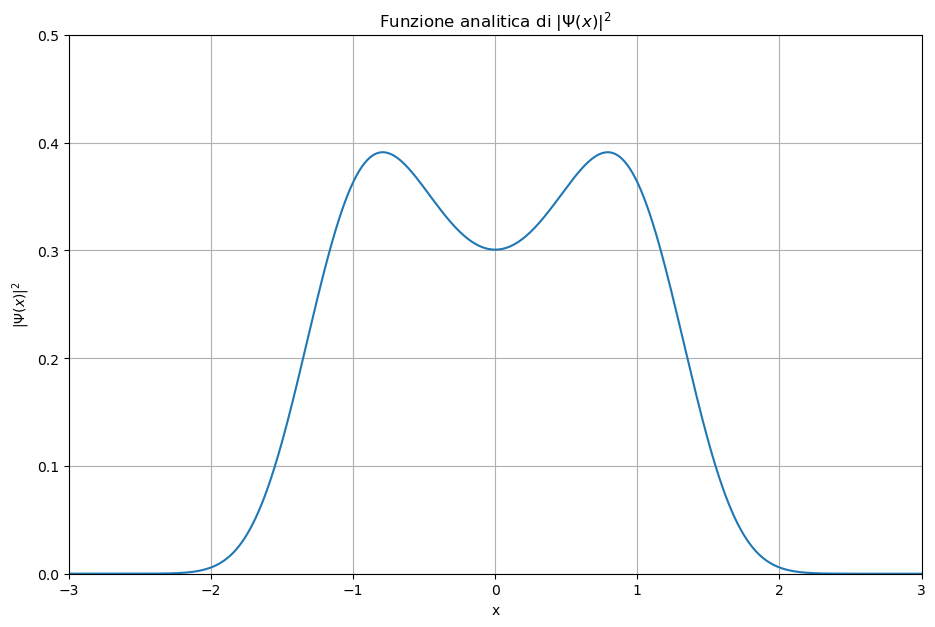

In [4]:
#import asynchat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math as mt

#Lettura file
filename = "output_instant.txt"
POS = pd.read_table(filename, delimiter = "\t" , usecols=(0,1) , names = ('Num','X') , header = 0)

#estrarre i dati dalle colonne del file di testo
POS['X'] = pd.to_numeric(POS['X'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
position_vector = POS['X']

plt.figure(figsize = (11,7))
plt.hist(position_vector, bins = 500, density = 'True')
plt.title("campionamenti complessivi di $|\Psi(x)|^2$")
plt.xlabel(" Posizione x")
plt.ylabel(" Campionamenti normaizzati")
plt.xlim((-3,3))
plt.ylim((0,0.5))
plt.grid(True)
plt.show()

## --- Funzione analitica

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(11,7))
scale = 0.3
#plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2)
#plt.plot(x,(psi[1])**2)
#plt.plot(x,(psi[2])**2)
plt.title("Funzione analitica di $|\Psi(x)|^2$")
plt.xlabel("x")
plt.ylabel("$|\Psi(x)|^2$")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((0,0.5))
plt.show()

Per ultimo, si valuta l'andamento dell'integrale <E> e della sua incertezza, al variare del numero di punti $x$ utilizzati per l'integrazione.

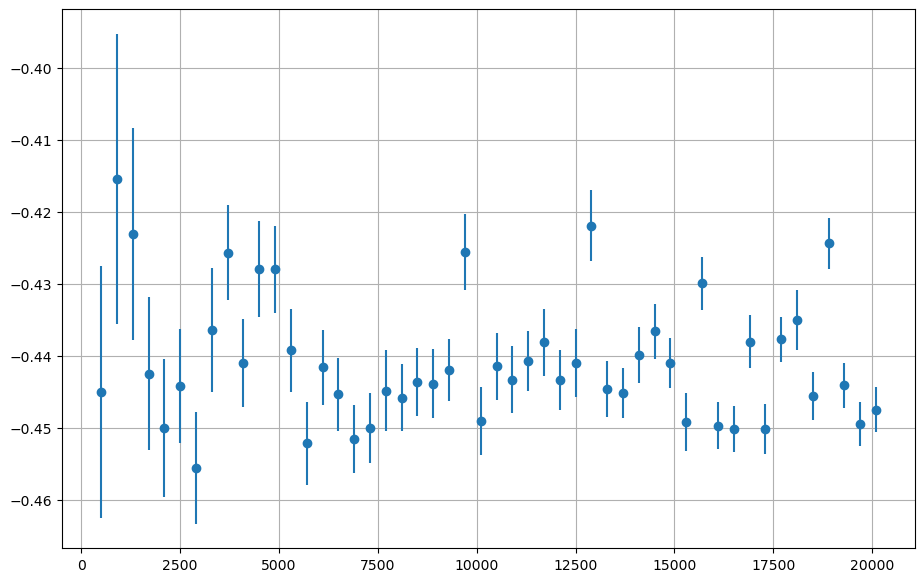

In [5]:
#Lettura file
filename = "Energies.txt"
E = pd.read_table(filename, delimiter = "\t" , usecols=(0,1,2) , names = ('Num','Media','Stdev') , header = 0)

#estrarre i dati dalle colonne del file di testo
E['Num'] = pd.to_numeric(E['Num'] , errors = 'coerce')
E['Media'] = pd.to_numeric(E['Media'] , errors = 'coerce')
E['Stdev'] = pd.to_numeric(E['Stdev'] , errors = 'coerce')

#caricare i dati estratti in rispettivi array
Points_vector = E['Num']
Media_vector = E['Media']
Stdev_vector = E['Stdev']

plt.figure(figsize = (11,7))
plt.errorbar(Points_vector, Media_vector, yerr = Stdev_vector, fmt = 'o')
plt.grid(True)
plt.show()